In [26]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot.plt as mp
import time

In [27]:
dete_temp = np.genfromtxt('lasp_dsse_hw/data/detectorTemp.txt', delimiter=',') #import delimited data
dete_temp = det_temp[1:] #trim off nans created from lable line

dist_dopp = np.genfromtxt('lasp_dsse_hw/data/distanceAndDoppler.txt', delimiter=',') #import delimited data
dist_dopp = dis_dop[1:] #trim off nans created from lable line

inst_tele = np.genfromtxt('lasp_dsse_hw/data/instrumentTelemetry.txt', delimiter=',') #import delimited data
inst_tele = inst_tele[1:] #trim off nans created from lable line

inte_time = np.genfromtxt('lasp_dsse_hw/data/integrationTime.txt', delimiter=',') #import delimited data
inte_time = inte_time[1:] #trim off nans created from lable line

# plans = np.genfromtxt('lasp_dsse_hw/data/plans.txt', delimiter=',') #import delimited data
# plans = plan[1:] #trim off nans created from lable line

refe_spec = np.genfromtxt('lasp_dsse_hw/data/referenceSpectrum.txt', delimiter=',') #import delimited data
refe_spec = refe_spec[1:] #trim off nans created from lable line


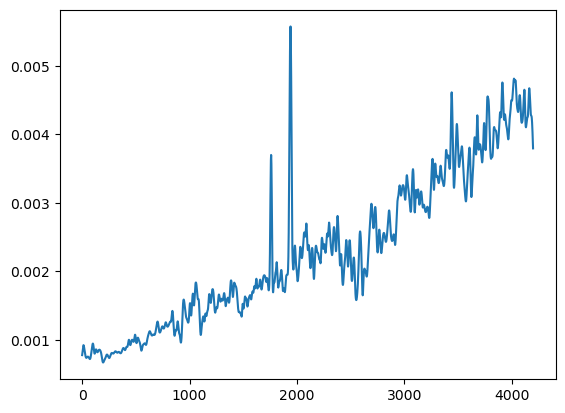

In [37]:
mp.plot(refe_spec[:,1]) #glance at the refernce spectrum to check sanity
#looks like the spectrum is binned by pixels, since this sensor isn't working from hard gamma rays to heat IR.
#todo calc wavelength values for the refernce, so we can have values for data after fitting.